In [124]:
%load_ext autoreload
%autoreload 2

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#import pymaise 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import psutil
import GPUtil

def get_gpu_utilization():
    # Get the list of available GPUs
    gpus = GPUtil.getGPUs()
    
    if len(gpus) == 0:
        print("No GPU found.")
        return
    
    for gpu in gpus:
        print(f"GPU {gpu.id}:")
        print(f"  - GPU name: {gpu.name}")
        print(f"  - GPU load: {gpu.load * 100:.2f}%")
        print(f"  - GPU memory total: {gpu.memoryTotal} MB")
        print(f"  - GPU memory used: {gpu.memoryUsed} MB")
        print(f"  - GPU memory free: {gpu.memoryFree} MB")
        print(f"  - GPU memory utilization: {gpu.memoryUtil * 100:.2f}%")
        print()

def main():
    # Print CPU utilization
    print("CPU utilization:", psutil.cpu_percent(interval=1))
    
    # Print GPU utilization
    get_gpu_utilization()

if __name__ == "__main__":
    main()


CPU utilization: 0.1
GPU 0:
  - GPU name: NVIDIA GeForce RTX 4090
  - GPU load: 0.00%
  - GPU memory total: 24564.0 MB
  - GPU memory used: 22758.0 MB
  - GPU memory free: 1458.0 MB
  - GPU memory utilization: 92.65%

GPU 1:
  - GPU name: NVIDIA GeForce RTX 4090
  - GPU load: 0.00%
  - GPU memory total: 24564.0 MB
  - GPU memory used: 556.0 MB
  - GPU memory free: 23660.0 MB
  - GPU memory utilization: 2.26%



In [126]:
from pyMAISE.datasets import load_anomaly
from pyMAISE.preprocessing import train_test_split, scale_data, one_hot_encode, SplitSequence
import pyMAISE as mai

In [127]:
%%time

global_settings = mai.init(
    problem_type=mai.ProblemType.CLASSIFICATION,   # Define a regression problem
    #cuda_visible_devices="-1"                  # Use CPU only/ Delete line when run on GPU
    verbosity = 3
)

Num GPUs Available:  2
CPU times: user 43 µs, sys: 6 µs, total: 49 µs
Wall time: 53.9 µs


In [128]:
# call handler
input_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL.npy"
output_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL_labels.npy"
#print(mai.__file__)
#False, False, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)  one hot
#False, True, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)
#False, False, True:  ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#False, True, True:   ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#True, False, True: WORKS        X.shape = (4846500, 14), Y.shape = (4846500, 1)
#True, True, True: WORKS         X.shape = (4846500, 14), Y.shape = (4846500, 1)
cond1 = True
cond2 = False
cond3 = True
inputs, outputs = load_anomaly([input_path, output_path], cond1, cond2, cond3)


In [129]:
inputs

<xarray.DataArray (timesteps: 4846500, features: 14)>
array([[-6.07100e+00,  5.55120e+00, -1.42220e+00, ..., -4.60370e-02,
         2.17170e+03,  1.27100e+00],
       [-4.85030e+00,  4.33040e+00, -2.64290e+00, ...,  1.50000e-02,
         2.17250e+03, -1.33776e+01],
       [-4.85030e+00,  1.88890e+00, -1.42220e+00, ...,  4.55190e-02,
         2.17320e+03, -8.49500e+00],
       ...,
       [-2.17470e+00, -7.57620e+00, -3.39550e+00, ..., -1.07070e-01,
         2.17220e+03,  1.19730e+01],
       [-4.61620e+00, -3.91400e+00, -5.83700e+00, ..., -1.68110e-01,
         2.17180e+03,  9.53200e+00],
       [-3.39550e+00, -6.35550e+00, -5.83700e+00, ..., -4.60370e-02,
         2.17150e+03,  9.53200e+00]], dtype=float32)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U18 'A+IGBT-I: current' ... 'DV/DT'

In [130]:
outputs

<xarray.DataArray (timesteps: 4846500, features: 1)>
array([['Run'],
       ['Run'],
       ['Run'],
       ...,
       ['Fault'],
       ['Fault'],
       ['Fault']], dtype=object)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U5 'Class'

In [131]:
outputs = one_hot_encode(outputs)
outputs

<xarray.DataArray (timesteps: 4846500, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'Class_Fault' 'Class_Run'

In [132]:
data = xr.concat([inputs, outputs], dim="features")
data

<xarray.DataArray (timesteps: 4846500, features: 16)>
array([[ -6.0710001 ,   5.55119991,  -1.42219996, ...,   1.27100003,
          0.        ,   1.        ],
       [ -4.85029984,   4.33039999,  -2.64289999, ..., -13.37759972,
          0.        ,   1.        ],
       [ -4.85029984,   1.88890004,  -1.42219996, ...,  -8.49499989,
          0.        ,   1.        ],
       ...,
       [ -2.17470002,  -7.57620001,  -3.39549994, ...,  11.97299957,
          1.        ,   0.        ],
       [ -4.61619997,  -3.91400003,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ],
       [ -3.39549994,  -6.35550022,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'A+IGBT-I: current' ... 'Class_Run'

In [133]:
split_sequence = SplitSequence(
    10, 
    1, 
    0, 
    sequence_inputs=data.coords["features"].values[:-2], 
    sequence_outputs=data.coords["features"].values[-2:],
)
inputs, outputs = split_sequence.split(data)

inputs

<xarray.DataArray (samples: 4846491, timesteps: 10, features: 14)>
array([[[-6.07100010e+00,  5.55119991e+00, -1.42219996e+00, ...,
         -4.60369997e-02,  2.17169995e+03,  1.27100003e+00],
        [-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        ...,
        [-3.62960005e+00,  1.88890004e+00, -5.08440018e+00, ...,
         -4.60369997e-02,  2.17239990e+03, -1.17100000e+00],
        [-7.29180002e+00,  1.88890004e+00, -3.86360002e+00, ...,
          1.49999997e-02,  2.17230005e+03, -1.33781004e+01],
        [-7.29180002e+00,  3.10969996e+00, -2.64289999e+00, ...,
         -4.60369997e-02,  2.17280005e+03, -1.17100000e+00]],

       [[-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        [-7.29180002e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17300000e+03, -2.31439991e+01],
...
        [-4.61619997e+00, -8.79699993e+00, -4.61619997e+00, ...,
          1.49999997e-02,  2.17180005e+03,  4.64900017e+00],
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00]],

       [[-7.05770016e+00, -7.57620001e+00, -3.39549994e+00, ...,
          1.06559999e-01,  2.17180005e+03,  7.09000015e+00],
        [-4.61619997e+00, -6.35550022e+00, -7.05770016e+00, ...,
         -4.60369997e-02,  2.17160010e+03,  7.09100008e+00],
        [-3.39549994e+00, -8.79699993e+00, -2.17470002e+00, ...,
         -4.60369997e-02,  2.17180005e+03,  1.19740000e+01],
        ...,
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00],
        [-3.39549994e+00, -6.35550022e+00, -5.83699989e+00, ...,
         -4.60369997e-02,  2.17150000e+03,  9.53199959e+00]]])
Coordinates:
  * samples    (samples) int64 0 1 2 3 4 ... 4846487 4846488 4846489 4846490
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [134]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler






In [135]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, outputs, test_size=0.3)



In [136]:
xtrain, xtest, x_scaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())



In [137]:
ytrain, ytest, y_scaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

In [138]:
%%time


xtrain = xtrain[:8000]
ytrain = ytrain[:8000]

xtest = xtest[:2000]
ytest = ytest[:2000]


CPU times: user 415 µs, sys: 58 µs, total: 473 µs
Wall time: 479 µs


In [139]:
xtrain.shape

(8000, 10, 14)

In [140]:
ytrain.shape[-1]

2

In [141]:
lstm_structure = {
    "LSTM_input": {
        "units": 50,
        "return_sequences": True,
        "input_shape": (xtrain.shape[1], xtrain.shape[2]),
    },
    "LSTM": {
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": 50,
        "return_sequences": True,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
#check activation to lstm to classification
    "LSTM_output": {
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",

        
    },
    "Dense":{
         "num_layers": mai.Int(min_value=0, max_value=3),
         "units": mai.Int(min_value=25, max_value=250),
         "activation": "sigmoid", #do research on relu activation CHANGED
         "kernel_initializer": "normal",
         "sublayer": mai.Choice(["Dropout_hidden", "None"]),
         "Dropout_hidden": {
         "rate": mai.Float(min_value=0.4, max_value=0.6),}
    },
    "Dense_output": {
        "units": ytrain.shape[1],
        "activation": "softmax",
    },
}
#change nodes in each layer, not in the output
fitting = {
    "batch_size":128,# mai.Choice([16, 32, 64]),
    "epochs": 5,
    "validation_split":0.15,
    "callbacks": [
        ReduceLROnPlateau(
            monitor='accuracy',
            factor=0.8,
            patience=2,
            min_lr=0,
            verbose=1,
        ),
        EarlyStopping(
            monitor="accuracy",
            patience=3,
        )
    ]
}
adam = {
    "learning_rate": mai.Float(min_value=0.00001, max_value=0.001),
   # "clipnorm": mai.Float(min_value=0.8, max_value=1.2),
  #  "clipvalue": mai.Float(min_value=0.3, max_value=0.7),
}
compiling = {
    "loss": "binary_crossentropy",#figure out accuracy on keras keras lstm on classification
    "metrics": ["accuracy"],
}

model_settings = {
    "models": ["LSTM"],
    "LSTM": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": adam,
        "compile_params": compiling,
        "fitting_params": fitting,
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

In [142]:
xtrain.shape

(8000, 10, 14)

In [143]:
lstm_structure

{'LSTM_input': {'units': 50,
  'return_sequences': True,
  'input_shape': (10, 14)},
 'LSTM': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x7de1e00c5e90>,
  'units': 50,
  'return_sequences': True,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'LSTM_output': {'units': 50,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'Dense': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x7deba6466790>,
  'units': <pyMAISE.utils.hyperparameters.Int at 0x7dec18541290>,
  'activation': 'sigmoid',
  'kernel_initializer': 'normal',
  'sublayer': <pyMAISE.utils.hyperparameters.Choice at 0x7dec185412d0>,
  'Dropout_hidden': {'rate': <pyMAISE.utils.hyperparameters.Float at 0x7de391720dd0>}},
 'Dense_output': {'units': 2, 'activation': 'softmax'}}

In [144]:
ytrain.shape

(8000, 2)

In [145]:

start = time.time()

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="accuracy_score",
    max_trials=2,
    cv=5,
)

print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 2 Complete [00h 00m 29s]
accuracy_score: 0.851375

Best accuracy_score So Far: 0.851375
Total elapsed time: 00h 00m 50s

Top Configurations

-- LSTM | Training Time: 00:00:50
LSTM_num_layers: 0
Dense_num_layers: 2
Adam_learning_rate: 0.0007098972840127918
Dense_0_units: 25
Dense_0_sublayer: Dropout_hidden
Dense_0_sublayer_Dropout_hidden_0_rate: 0.4
Dense_1_units: 25
Dense_1_sublayer: Dropout_hidden
Dense_1_sublayer_Dropout_hidden_0_rate: 0.4
Hyperparameter tuning took 0.8363776286443074 minutes to process.


In [146]:
xtrain

<xarray.DataArray (samples: 8000, timesteps: 10, features: 14)>
array([[[0.60668861, 0.16664057, 0.48261248, ..., 0.5075606 ,
         0.93643707, 0.39315266],
        [0.60852243, 0.17587519, 0.49247607, ..., 0.50664355,
         0.93648232, 0.36416787],
        [0.61188413, 0.18701412, 0.51014638, ..., 0.50480959,
         0.93670836, 0.33389486],
        ...,
        [0.61432906, 0.23699585, 0.78959342, ..., 0.49793199,
         0.93612063, 0.25769212],
        [0.61555152, 0.24623048, 0.78959342, ..., 0.49518098,
         0.93612063, 0.2637368 ],
        [0.6131066 , 0.2564303 , 0.78959342, ..., 0.48784485,
         0.93648232, 0.27463707]],

       [[0.46824554, 0.6013124 , 0.44850735, ..., 0.47408995,
         0.84416697, 0.56493088],
        [0.43004456, 0.6000386 , 0.46372354, ..., 0.47592436,
         0.84439754, 0.55526929],
        [0.39184358, 0.59940183, 0.47315959, ..., 0.48601135,
         0.84451503, 0.54436903],
...
        [0.60510189, 0.49614701, 0.80505199, ..., 0.50068305,
         0.91966485, 0.48826736],
        [0.60479636, 0.49614701, 0.8058739 , ..., 0.50068305,
         0.91966485, 0.48464054],
        [0.60449073, 0.49614701, 0.8058739 , ..., 0.4997661 ,
         0.91943881, 0.48101373]],

       [[0.6032683 , 0.60728452, 0.80546296, ..., 0.48692795,
         0.91943881, 0.3975623 ],
        [0.60296267, 0.60792142, 0.80464105, ..., 0.48784485,
         0.91943881, 0.40117921],
        [0.60479636, 0.60760295, 0.80546296, ..., 0.48784485,
         0.91952921, 0.4072239 ],
        ...,
        [0.60907495, 0.61078744, 0.80710685, ..., 0.48784485,
         0.91998129, 0.4289947 ],
        [0.60938063, 0.61142431, 0.80875067, ..., 0.48692795,
         0.92047857, 0.43504435],
        [0.60938063, 0.61206135, 0.80875067, ..., 0.48692795,
         0.92034298, 0.44351187]]])
Coordinates:
  * samples    (samples) int64 2527129 4763537 1580470 ... 274430 3162611
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [147]:
ytrain.shape

(8000, 2)

In [148]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 10}},
    },
  #  y_scaler=y_scaler,
)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
63/63 [==============================] - 1s 1ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00048616416752338414.
Epoch 5/5
63/63 [==============================] - 1s 2ms/step


In [149]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
1,LSTM,"{'LSTM_num_layers': 1, 'Dense_num_layers': 1, ...",0.859750,0.859750,0.859750,0.859750,0.856,0.856,0.856,0.856
0,LSTM,"{'LSTM_num_layers': 0, 'Dense_num_layers': 2, ...",0.851375,0.851375,0.851375,0.851375,0.851,0.851,0.851,0.851


In [150]:
for model in [ "LSTM"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: LSTM
LSTM_num_layers: 1
Dense_num_layers: 1
Adam_learning_rate: 0.000607705234140828
Dense_0_units: 121
Dense_0_sublayer: Dropout_hidden
Dense_0_sublayer_Dropout_hidden_0_rate: 0.45632907449291593
Dense_1_units: 70
Dense_1_sublayer: Dropout_hidden
Dense_1_sublayer_Dropout_hidden_0_rate: 0.512434195991135



In [151]:
idx = postprocessor._get_idx()
idx

1

In [152]:
#postprocessor._models()
yhat_test = postprocessor._models["Test Yhat"][idx]

In [153]:
postprocessor.get_model()

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [154]:
 yhat_test

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [155]:
#postprocessor.confusion_matrix(model_type = "LSTM")
yhat_train = postprocessor._models["Train Yhat"][idx]
yhat_test = postprocessor._models["Test Yhat"][idx]


In [156]:
ytrain = postprocessor._ytrain.values
ytest = postprocessor._ytest.values

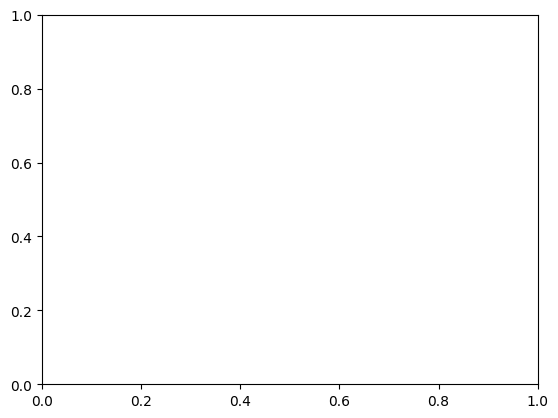

In [157]:
ax = plt.gca()

In [158]:
from sklearn.preprocessing import StandardScaler

ytrain = y_scaler.inverse_transform(
                ytrain.reshape(-1, ytrain.shape[-1])
            )
ytest = y_scaler.inverse_transform(ytest.reshape(-1, ytest.shape[-1]))

In [159]:
ytrain = np.round(ytrain).astype(int)
ytrain.shape

(8000, 2)

In [160]:
yhat_train.shape

(8000, 2)

In [161]:
yhat_train_single = np.argmax(yhat_train, axis=1)

In [162]:
ytrain_single = np.argmax(ytrain, axis=1)

In [163]:
yhat_train_single.shape

(8000,)

In [164]:
ytrain_single.shape

(8000,)

In [165]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(ytrain_single , yhat_train_single)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)


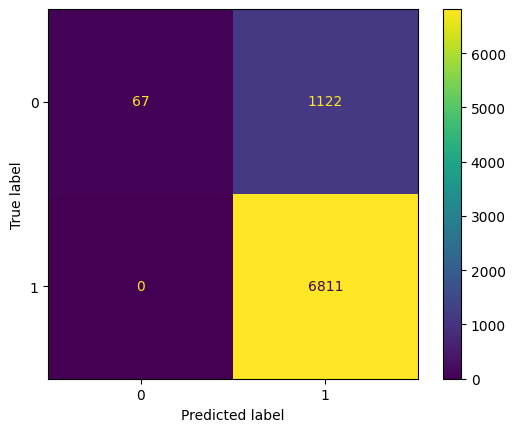

In [166]:
train_disp.plot()

In [176]:
ytest = np.round(ytest).astype(int)
ytest.shape

(2000, 2)

In [177]:
yhat_test.shape

(2000, 2)

In [178]:
yhat_test_single = np.argmax(yhat_test, axis=1)

In [179]:
ytest_single = np.argmax(ytest, axis=1)

In [180]:
yhat_test_single.shape

(2000,)

In [181]:
ytest_single.shape

(2000,)

In [182]:
test_cm = postprocessor.confusion_matrix(ytest_single, yhat_test_single)
test_disp = postprocessor.ConfusionMatrixDisplay(confusion_matrix=test_cm)



ValueError: Found input variables with inconsistent numbers of samples: [8000, 2000]

In [183]:
test_disp.plot()

NameError: name 'test_disp' is not defined